In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(42)

### Make Data 

$$ {\cal D} = \{(Phi_i, y_i)\}_{i=1}^N$$
\begin{align}
y_i & = \sin(2\pi Phi_i) + \epsilon_{n,i}, \quad i=1,\ldots,N
\end{align}
$$ \epsilon_{n,i} \sim {\cal N}(0, \sigma_n^2)$$

In [3]:
sigma_n = 0.1

N = 20
x = 2*np.random.rand(N)-1

y = np.sin(2*np.pi*x) + sigma_n * np.random.randn(N)

Text(0.5, 1.0, 'X space')

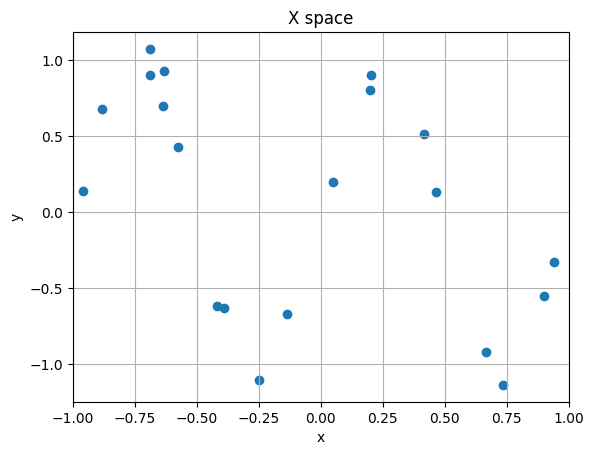

In [4]:
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([-1, 1])
# plt.ylim([-1, 1])
plt.grid()
plt.title('X space')

### Feature mapping

$$ x \mapsto \phi(x) \in \mathbb{R}^F$$
$$ \mathbf{w} \in \mathbb{R}^F $$

ex) polynomial feature

$$ \mathbf{w} = (w_p, w_{p-1},\ldots,w_0) \in \mathbb{R}^F, \quad \phi(x_i) = ((x_i/s)^p, (x_i/s)^{p-1}, \ldots, (x_i/s), 1) \in \mathbb{R}^{F}, \quad F = p+1$$

In [5]:
def getPolyFeature(x, p, scale=1):
    Phi = np.ones((p+1, len(x)))
    for i in range(p+1):
        Phi[i] = (x/scale)**(p-i)
    return Phi
p = 5
scale = 0.3
F = p+1
Phi = getPolyFeature(x, p, scale)
print(Phi.shape)

(6, 20)


### Likelihood model

\begin{align}
y_i & = \mathbf{w}^\top  \phi(x_i) + \epsilon_i
\end{align}
$$ \epsilon_i \sim {\cal N}(0, \sigma^2)$$

$$p(y|x,\mathbf{w}) = {\cal N}(\mathbf{w}^\top  \phi(x), \sigma^2)$$

#### For multiple data

$$p(\mathbf{y}|X,\mathbf{w}) = \prod_{i=1}^N p(y_i|x_i,\mathbf{w})$$
$$\mathbf{y} = (y_1, \ldots, y_N) \in \mathbb{R}^N, \quad X = (x_1, \ldots, x_N) \in \mathbb{R}^N $$

\begin{align}
\log p(\mathbf{y}|X,\mathbf{w}) & = \sum_{i=1}^N \log p(y_i|x_i,\mathbf{w})\\
& = \sum_{i=1}^N - \frac{1}{2} \log(2\pi\sigma^2) -\frac{1}{2\sigma^2}(\mathbf{w}^\top \phi(x_i) - y_i)^2 
\end{align}

In [6]:
sigma = 0.3

def likelihood_model(w, X, y, sigma):
    # w shape: (dim, N_w)
    # X shape: (dim, N)
    # y shape: (N)
    log_likelihood = -0.5*np.log(2*np.pi*sigma**2) -0.5/sigma**2*(np.dot(w.T, X) - y[np.newaxis,:])**2
    return np.exp(np.sum(log_likelihood, axis=1))

In [7]:
NN = 10
w = np.random.randn(F,NN)
likelihood_model(w, Phi, y, sigma)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Prior distribution

$$ \mathbf{w} \sim {\cal N}(0, \sigma_0^2  I) $$

$\sigma_0 = 0.5$

In [8]:
sigma0 = 0.5

In [9]:
def plot_prior(sigma0, F, w1min=-1, w1max=1, w2min=-1, w2max=1, xmin=-1, xmax=1, ymin=-1, ymax=1):
    
    mean_w_prior = np.zeros(F)
    cov_w_prior = sigma0**2 * np.eye(F)
    N_w = 10
    w_s_prior = np.random.multivariate_normal(mean_w_prior, cov_w_prior, N_w)
    
    plt.figure(figsize=(8,4))

    plt.subplot(1,2,1)
    # plt.scatter([1],[1])

    ################### samples from posterior ###################
    plt.subplot(1,2,2)
    x_grid = np.linspace(xmin, xmax, 101)
    p = F-1
    Phi_grid = getPolyFeature(x_grid, p, scale)
    for w in w_s_prior:
        plt.plot(x_grid, Phi_grid.T @ w, 'r')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])
    plt.grid()
    plt.title('X space - samples from prior')

    # Show the plot
    plt.tight_layout()
    plt.show()

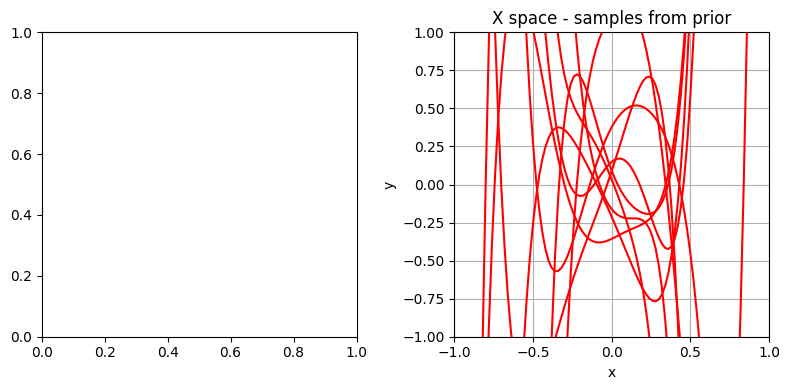

In [10]:
plot_prior(sigma0, F)

### Posterior distribution after observations

$$ \mathbf{w} \sim p(\mathbf{w}|X, y) = {\cal N}(\mu_w, \Sigma_w)$$
$$ \mu_w = \left(\sum_{i=1}^N \phi(x_i) \phi(x_i)^\top + \frac{\sigma^2}{\sigma_0^2} I\right)^{-1}\left(\sum_{i=1}^N \phi(x_i) y_i\right) = \left(\Phi \Phi^\top + \frac{\sigma^2}{\sigma_0^2} I\right)^{-1} \Phi y$$
$$ \Sigma_w = \sigma^2 \left(\sum_{i=1}^N \phi(x_i) \phi(x_i)^\top + \frac{\sigma^2}{\sigma_0^2} I\right)^{-1} = \sigma^2 \left(\Phi \Phi^\top + \frac{\sigma^2}{\sigma_0^2} I\right)^{-1}$$
$$ \Phi = [\phi(x_1) \ldots \phi(x_N)] \in \mathbb{R}^{F \times N} $$

In [11]:
def posterior_mean_cov(X, y, sigma0, sigma):
    # X shape (dim, N)
    # y shape (N)
    
    # mu_w shape (dim,)
    # Sigma_w shape (dim,dim)
    
    dim = X.shape[0]
    mat = np.linalg.inv(np.dot(X, X.T) + sigma**2/sigma0**2 * np.eye(dim))
    mu_w = np.dot(mat, np.dot(X, y))
    Sigma_w = sigma**2*mat
    return mu_w, Sigma_w

### Predictive distribution

$$ y_{new} \sim {\cal N}(\mu_{y_{new}|x_{new},{\cal D}}, \Sigma_{y_{new}|x_{new},{\cal D}})$$
$$\mu_{y_{new}|x_{new},{\cal D}} = \phi(x_{new})^\top \mu_w = \phi(x_{new})^\top \left(\Phi \Phi^\top + \frac{\sigma^2}{\sigma_0^2} I\right)^{-1} \Phi y$$
$$\Sigma_{y_{new}|x_{new},{\cal D}} = \sigma^2 +\phi(x_{new})^\top \Sigma_w \phi(x_{new}) = \sigma^2 \left(1+\mathbf{x}_{new}^\top \left(\Phi \Phi^\top + \frac{\sigma^2}{\sigma_0^2} I\right)^{-1}\phi(x_{new}) \right)$$

In [12]:
def predictive_mean_var(Xnew, X, y, sigma0, sigma):
    # Xnew shape (dim, Nnew)
    # X shape (dim, N)
    # y shape (N)

    mu_w, Sigma_w = posterior_mean_cov(X, y, sigma0, sigma)

    XnewT = Xnew.T
    mu_ynew = np.dot(XnewT, mu_w)
    
    var_ynew = sigma**2 + np.matmul(np.matmul(XnewT[:,np.newaxis,:], Sigma_w), XnewT[:,:,np.newaxis])
    return mu_ynew, var_ynew[:,0,0]

In [13]:
def plot_predictions(Phi, y, sigma0, sigma, w1min=-1, w1max=1, w2min=-1, w2max=1, xmin=-1, xmax=1, ymin=-1, ymax=1):

    plt.figure(figsize=(8,4))

    ################### samples from posterior ###################
    mu_w, Sigma_w = posterior_mean_cov(Phi, y, sigma0, sigma)
    N_w = 10
    w_s = np.random.multivariate_normal(mu_w, Sigma_w, N_w)
    
    plt.subplot(1,2,1)
    x_grid = np.linspace(xmin, xmax, 101)
    
    # apply feature mapping
    Phi_grid = getPolyFeature(x_grid, p, scale)
    
    for w in w_s:
        plt.plot(x_grid, Phi_grid.T @ w, 'r')
    
    plt.scatter(x[:Ndata], y[:Ndata])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])
    plt.grid()
    plt.title('X space - samples from posterior')

    ################### predictive distribution ###################
    plt.subplot(1,2,2)
    x_new = np.linspace(xmin, xmax, 101)
    
    # apply feature mapping
    Phi_new = getPolyFeature(x_new, p, scale)
    
    mu_ynew, var_ynew = predictive_mean_var(Phi_new, Phi, y, sigma0, sigma)
    std_ynew = np.sqrt(var_ynew)
    plt.scatter(x[:Ndata], y[:Ndata])
    
    plt.plot(x_new, mu_ynew)
    plt.fill_between(x_new, mu_ynew - std_ynew, mu_ynew + std_ynew, alpha=0.5)
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])
    plt.grid()
    plt.title('X space - predictive distribution')
    
    
    # Show the plot
    plt.tight_layout()
    plt.show()

In [14]:
w1min=-2
w1max=2
w2min=-2
w2max=2
xmin=-1
xmax=1
ymin=-1.5
ymax=1.5

Single observation

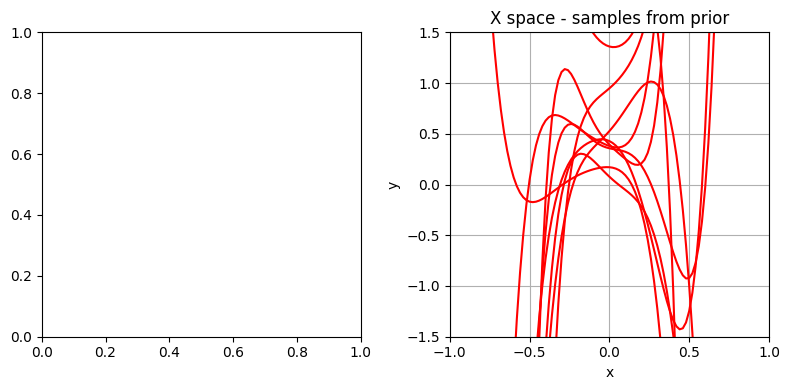

In [15]:
plot_prior(sigma0, F, w1min=w1min, w1max=w1max, w2min=w2min, w2max=w2max, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

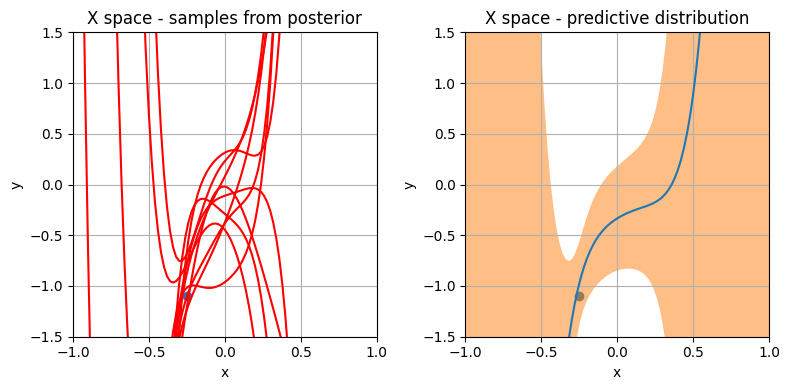

In [16]:
Ndata = 1
plot_predictions(Phi[:,:Ndata], y[:Ndata], sigma0, sigma, w1min=w1min, w1max=w1max, w2min=w2min, w2max=w2max, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

Two observations

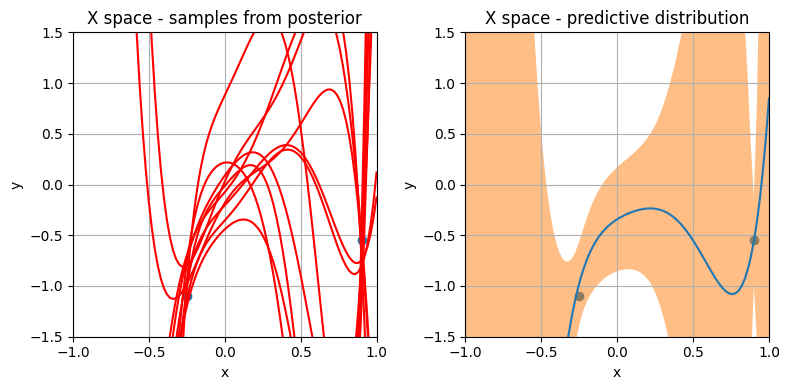

In [17]:
Ndata = 2
plot_predictions(Phi[:,:Ndata], y[:Ndata], sigma0, sigma, w1min=w1min, w1max=w1max, w2min=w2min, w2max=w2max, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

Twenty observations

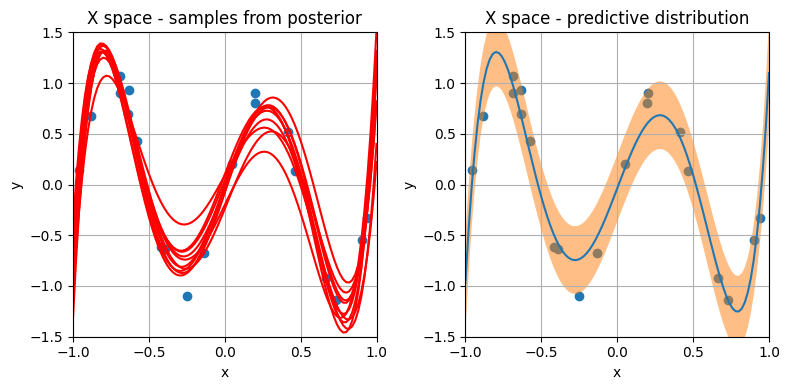

In [18]:
Ndata = 20
plot_predictions(Phi[:,:Ndata], y[:Ndata], sigma0, sigma, w1min=w1min, w1max=w1max, w2min=w2min, w2max=w2max, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)